# Clustering the Countries by using Unsupervised Learning for HELP International

Objective: To categorise the countries using socio-economic and health factors that determine the overall development of the country.

The dataset was downloaded from [KAGGLE.COM](https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data)

The dataset contains 167 observation one for each country. 
The total number of features are 10. the are: Country-name of country, child mortality- number of deaths of children under the age of  per 1000 births, exports- exports of goods and services per capita, health- total expence on healthcare per capita (as a percentage of GDP), imports- imports of goods and services per capita, inflation- measurament of annual growth of GDP, life expectancy - average number of years a new born child would live, fertility - number of children that would be born to each woman, GDP- GDP per capita.

Methods: Different unsupervised learning algorithms were tried ( Kmeans, Hierarchical clustering, DBSCAN) and the best approach was selected. Differnet approaches were tried for dimensionality reduction to visualize separate clusters.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn import datasets, metrics
import glob
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import time
import plotly.express as px
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import fetch_openml
import umap
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

In [ ]:
#dataset from kagge on different countries economic data
df_country=pd.read_csv('Country-data.csv')

In [ ]:
#0 missing values
df_country.isnull().sum().sum()

0

In [ ]:
df_country

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [ ]:
df_country.shape

(167, 10)

In [ ]:
#drop the first column which contains country names, we will comeback to it after selecting clusters
df=df_country.drop('country', axis=1)
columns=df.columns

In [ ]:
# Standarizing the features, Most of the clustering algorithms are sensitive to the scale of the data. So, before applying k-means, 
#we also standardize our variables using the StandardScaler from sklearn.preprocessing:
scaler = StandardScaler()
X_std = scaler.fit_transform(df)


# Elbow method for finding # of clusters

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

Two methods could be used, comparing distortions to number of clusters n_clusters, or comparing inertia to number of clusters.

Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
Inertia: It is the sum of squared distances of samples to their closest cluster center.

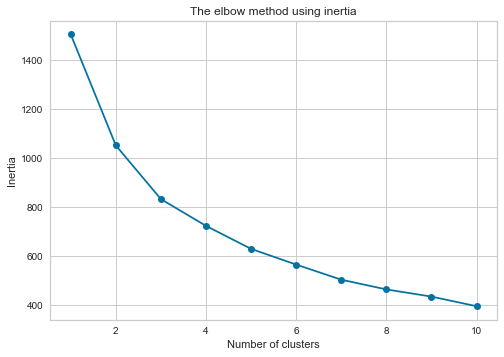

In [ ]:
sse = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_std)
    sse.append(km.inertia_)

# plot
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The elbow method using inertia')
plt.show()

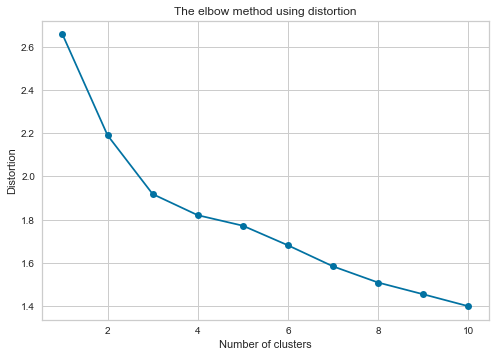

In [ ]:
sse = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_std)
    sse.append(sum(np.min(cdist(X_std, km.cluster_centers_,
                                   'euclidean'), axis=1)) / X_std.shape[0])

# plot
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The elbow method using distortion')
plt.show()

it looks like 3 clusters is a good option, there's no really an obvious elbow, it could be that datapoints are too close together. Let's visualize data using PCA dimencionality reduction method and try a different approach

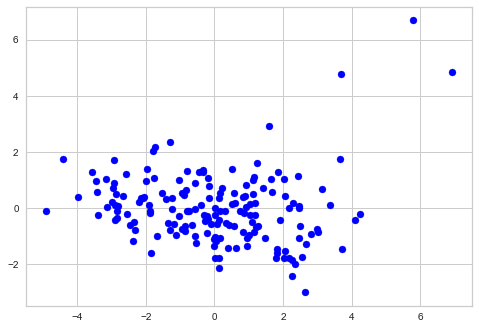

In [ ]:
pca = PCA(n_components=2).fit_transform(X_std)

# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c='blue')
plt.show()

the scatter plot confirmed there are no obvious clusters. Let's try silhouette analysis.
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually

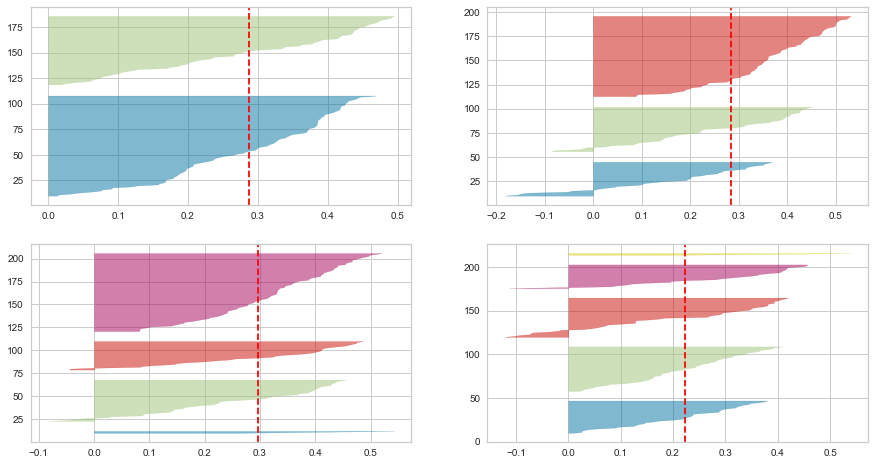

In [ ]:
fig,ax = plt.subplots(2,2, figsize = (15,8))
for i in [2,3,4,5]:

    # create kmeans instance for different numbers of clusters
    km = KMeans(n_clusters=i, init= 'random', n_init =10, max_iter = 300, random_state = 123)
    q, mod = divmod(i,2)
    
    #create visualiser
    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_std)

from plots above it is obvious 4 and 5 are not good choices. 4 has one very small cluster, 5 -msilhouette score is very low. 2 and 3 are good choices. I will choose 3 clusters. This way we'll have 3 groups of countries, poor countries that might need a lot of help, medium developped countries and wealthy countries.

# Kmeans clustering

In [ ]:
# Defining the k-means
kmeans_cluster = KMeans (
    n_clusters = 3, # number of clusters/centroids to create
    init = 'random', # ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids
    n_init = 10, # this is the default value. This is the number of times the k-means algorithm will be run with different centroid seeds
    max_iter = 300, # this is the default value. This is the maximum number of iterations of the k-means algorithm for a single run.
    tol = 1e-4, # this is the default value. This is the relative tolerance with regards to Frobenius norm of the difference in the cluster centers of two consecutive iterations to declare convergence.
    random_state = 0 # this is the default value. Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.
)

# Fit model
%timeit kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

52.5 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


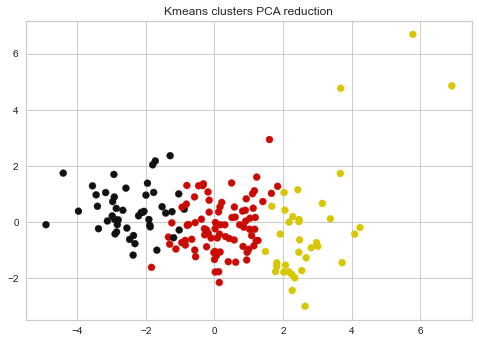

In [ ]:
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'y'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in y_pred]
# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=label_color)
plt.title('Kmeans clusters PCA reduction')
plt.show()

In [ ]:
#calculate silhoette score
print("The silhoutte score of the K-means solution: {}"
      .format(metrics.silhouette_score(X_std, y_pred, metric='euclidean')))

The silhoutte score of the K-means solution: 0.28329575683463126


Since we don't know ground truth, we can't calculate rand index score.
Let's add our selected clusters to dataset as ground truth and compare other clustering algorithms

In [ ]:
df_standard = pd.DataFrame(data= X_std , columns = columns)
# add the cluster column to the dataframe 
df_standard['cluster'] = y_pred
df_standard.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180,1
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623,0
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376,0
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268,1
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817,0


# Agglomerative clustering

In [ ]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

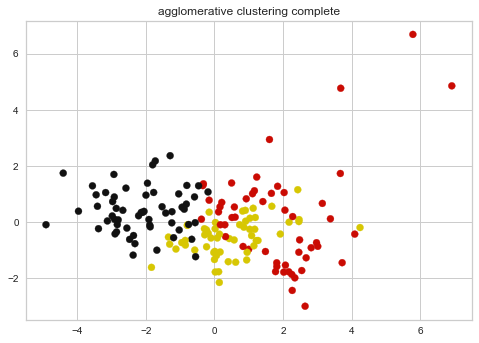

In [ ]:
pca = PCA(n_components=2).fit_transform(X_std)
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'y'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in clusters]
# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=label_color)
plt.title('agglomerative clustering complete')
plt.show()

In [ ]:
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
      .format(metrics.adjusted_rand_score(y_pred, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution complete: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.4104405122640288
The silhoutte score of the Agglomerative Clustering solution complete: 0.15473277820023112


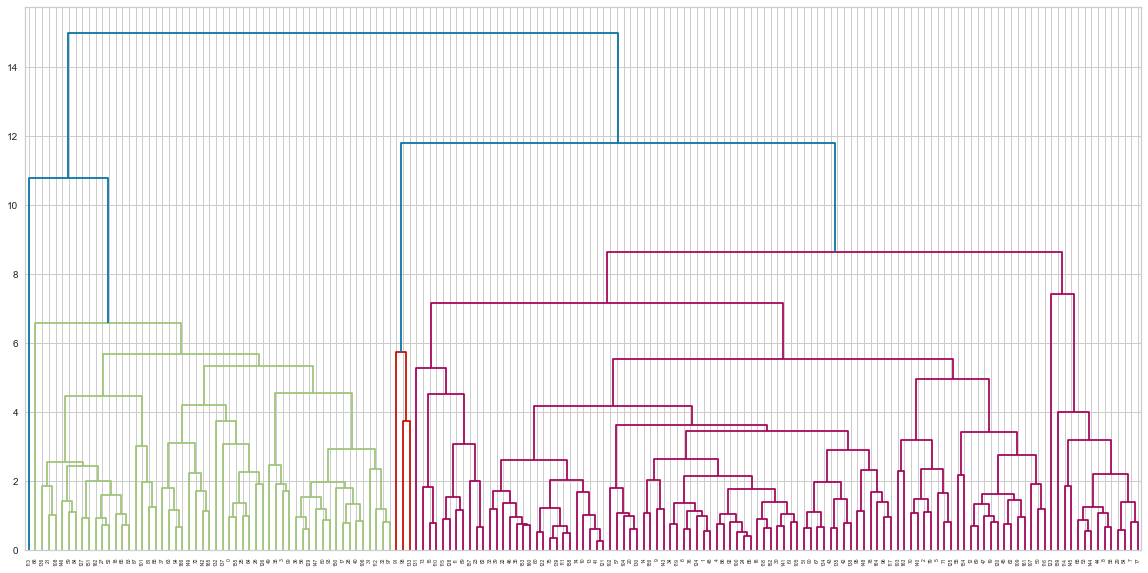

In [ ]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'))
plt.show()

In [ ]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=3)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

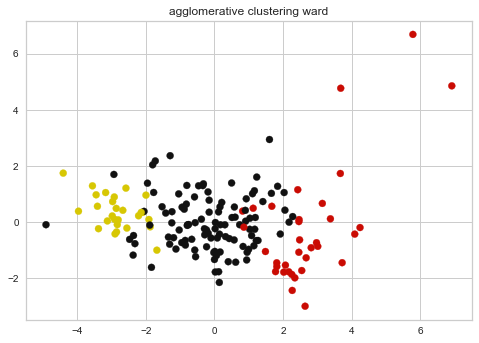

In [ ]:
pca = PCA(n_components=2).fit_transform(X_std)
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'y'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in clusters]
# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=label_color)
plt.title('agglomerative clustering ward')
plt.show()

In [ ]:
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
      .format(metrics.adjusted_rand_score(y_pred, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution ward: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.5370443541852963
The silhoutte score of the Agglomerative Clustering solution ward: 0.24563001303300652


In [ ]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=3)

# Fit model
clusters = agg_cluster.fit_predict(X_std)


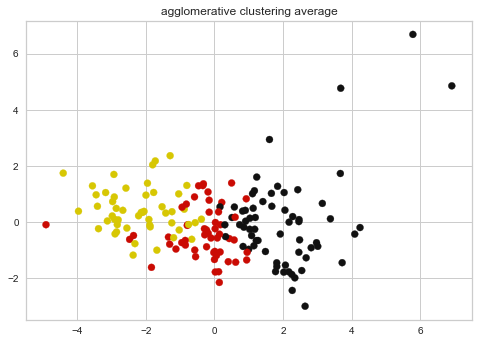

In [ ]:
pca = PCA(n_components=2).fit_transform(X_std)
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'y'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in clusters]
# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=label_color)
plt.title('agglomerative clustering average')
plt.show()

In [ ]:
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
      .format(metrics.adjusted_rand_score(y_pred, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution average: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.46130029532188016
The silhoutte score of the Agglomerative Clustering solution average: 0.18519498231173862


The ward linkage method was the best based on silhouette score, but K means performed better. Let's see ward dendrogram

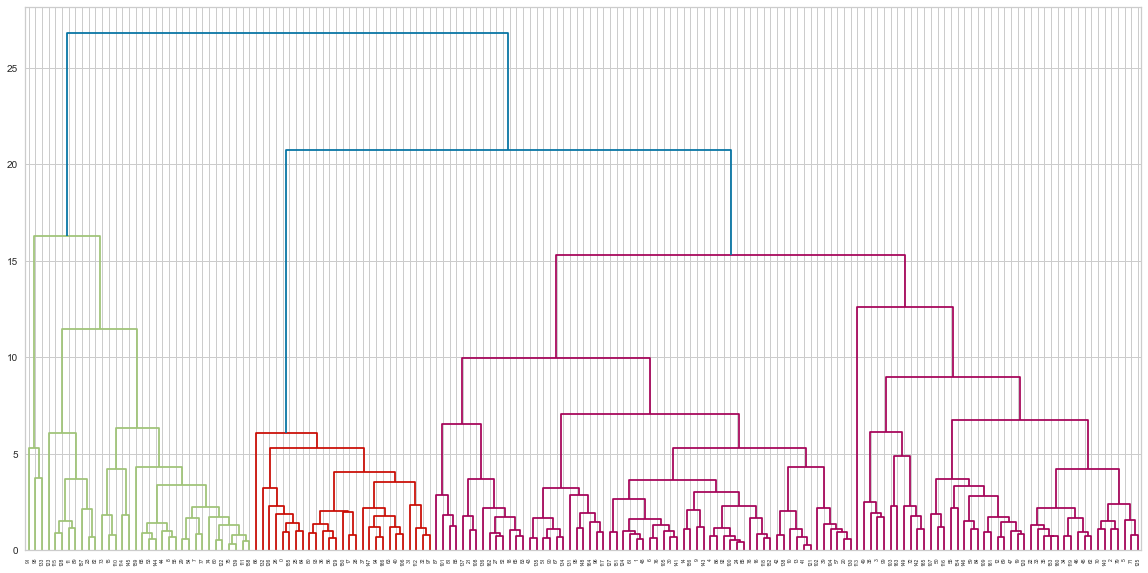

In [ ]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='ward'))
plt.show()

we can see better clusters compared to other linkage methods

# Dbscan

In [ ]:
# determine the best value for eps , using the approach in 
# https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

#DMDBSCAN - Dynamic Method for DBSCAN to determine epsilon
neigh = NearestNeighbors(n_neighbors=16)
nbrs = neigh.fit(X_std)
distances, indices = nbrs.kneighbors(X_std)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]
fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threashold (espsilon)')
fig.show()

In [ ]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=4, min_samples=20)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

In [ ]:
clusters

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

yielded one cluster with minimum noise for only 3 samples

Dbscan was able to find only one cluster with some noise samples. This is due to the fact that our datapoints don't have distinctive boarder


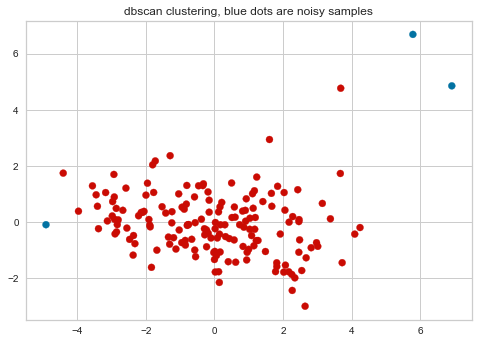

In [ ]:
pca = PCA(n_components=2).fit_transform(X_std)
LABEL_COLOR_MAP = {0 : 'r',
                   -1 : 'b'
                   
                   }

label_color = [LABEL_COLOR_MAP[l] for l in clusters]
# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=label_color)
plt.title('dbscan clustering, blue dots are noisy samples')

plt.show()

As we can see from the above comparison Kmeans algorithm yielded best results, hierarchcal clustering resulted in lower silhoette score and DBSCAN found only one cluster. Below we'll  try different dimensionality reduction methods to visualize clusters:

# Dimensionality reduction

## UMAP

In [ ]:
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.6,
                      metric='correlation').fit_transform(X_std)

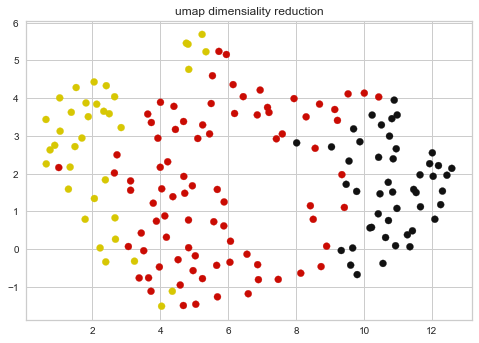

In [ ]:
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'y'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in y_pred]
# Plot the solution.
plt.scatter(umap_results[:,0], umap_results[:,1], c=label_color)
plt.title('umap dimensiality reduction')
plt.show()

min_dist=0.6, n_neighbors=20 produces best cluster separation

## TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=120, n_iter=500)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 167 samples in 0.000s...
[t-SNE] Computed neighbors for 167 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 167 / 167
[t-SNE] Mean sigma: 2.787100
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.502155
[t-SNE] KL divergence after 500 iterations: 0.031981


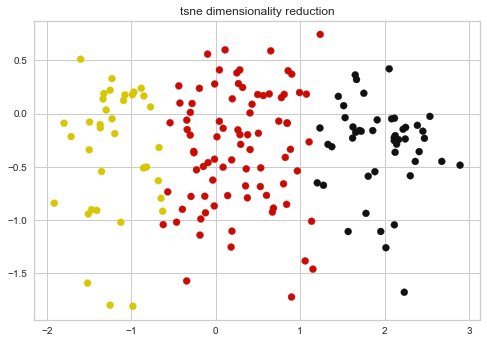

In [ ]:
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'y'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in y_pred]
# Plot the solution.
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_color)
plt.title('tsne dimensionality reduction')
plt.show()

# PCE

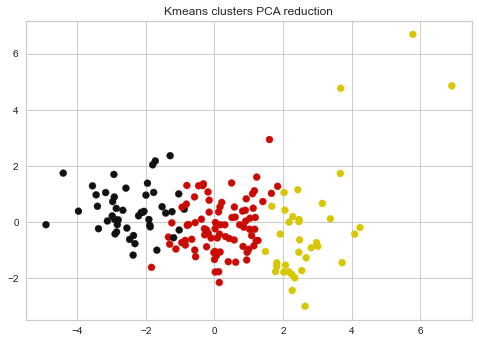

In [ ]:
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'y'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in y_pred]
# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=label_color)
plt.title('Kmeans clusters PCA reduction')
plt.show()

Out of 3 methods TSNE produced best cluster representation, PCA had outliers and UMAP clusters were too intermingled

In [ ]:
cntr_df=pd.concat([df_country['country'], df_standard['cluster']],axis=1)

In [ ]:
cntr_df[cntr_df['cluster']==0]['country']

1                  Albania
2                  Algeria
4      Antigua and Barbuda
5                Argentina
6                  Armenia
              ...         
160                Uruguay
161             Uzbekistan
162                Vanuatu
163              Venezuela
164                Vietnam
Name: country, Length: 84, dtype: object

In [ ]:
countries={ '0' : cntr_df[cntr_df['cluster']==0]['country'].reset_index(),
           '1' : cntr_df[cntr_df['cluster']==1]['country'].reset_index(),
           '2' : cntr_df[cntr_df['cluster']==2]['country'].reset_index()
    
}

In [ ]:
countries

{'0':     index              country
 0       1              Albania
 1       2              Algeria
 2       4  Antigua and Barbuda
 3       5            Argentina
 4       6              Armenia
 ..    ...                  ...
 79    160              Uruguay
 80    161           Uzbekistan
 81    162              Vanuatu
 82    163            Venezuela
 83    164              Vietnam
 
 [84 rows x 2 columns],
 '1':     index                   country
 0       0               Afghanistan
 1       3                    Angola
 2      17                     Benin
 3      21                  Botswana
 4      25              Burkina Faso
 5      26                   Burundi
 6      28                  Cameroon
 7      31  Central African Republic
 8      32                      Chad
 9      36                   Comoros
 10     37          Congo, Dem. Rep.
 11     38               Congo, Rep.
 12     40             Cote d'Ivoire
 13     49         Equatorial Guinea
 14     50               

# Conclusion

K means clustering method produced best results, the underlying datapoints were located with more or less the same density,
with a few ouliers. The TSNE dimensionality reduction method yielded best cluster representation.